In [1]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


65536/57026 [==================================] - 0s 1us/step


In [2]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)

train_data /= std
test_data -= mean
test_data /= std

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers

def build_model():
    # Because we will need to instantiate
    # the same model multiple time,
    # we use a function to construct it.
    model = models.Sequential()
    model.add(layers.Dense(48, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

In [4]:
%%time
import numpy as np
k = 4
num_val_samples = len(train_data) // k
num_epochs = 80
batch_size = 16
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    # Prepare the validation data: data from partition # k
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    # Prepare the training data: data from all other partitions
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
        train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
        train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    # Build the keras model (already compiled)
    model = build_model()
    # Train the model (silen mode, verbose=0)
    history = model.fit(partial_train_data, partial_train_targets,
        validation_data=(val_data, val_targets),
        epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
CPU times: user 8.12 s, sys: 704 ms, total: 8.82 s
Wall time: 6.69 s


In [5]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

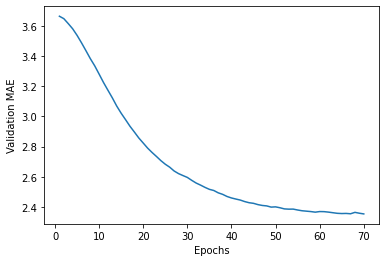

2.3131714463233948


In [6]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

print(average_mae_history[-1])